## [Lecture 10.2: Bagging and Random Forest](https://www.youtube.com/watch?v=CJ3KQYsJPVI)

### Random Forests
Random forest is a bagging technique that trains multiple trees with minor modification in split criterion

<img src= "images/RandomForest.png" />

In case of a decision Tree, we train a single decision tree. In random forest we train multiple decision tree on different training sets obtained through bootstrap aggregation.

### Random Forest - The algorithm
**Input**:

Training data $D$ with shape $(n,m)$, where $n$ is the number of examples and $m$ is the number of features

**Steps**:

1. Sample $q$ datasets each of the shape $(n,m)$ say $D_1, D_2,....,D_q$ with replacement from $D$.
2. In each of the dataset $D_j$ select $u$ out of $m$ where $u \le m$ features before each split and train a full decision tree $h_j(\mathbf{x})$
3. The final predictor is :
   - For regression, an average output from $q$ regressors is assigned to the new example:
   $$
      h(\mathbf{x}) = \frac{1}{q} \sum_{j=1}^q h_j(\mathbf{x})
   $$
   - For classification, a majority voting is taken and the class label with maximum number of votes is assigned to the new example.

### Implementation
In order to keep the implementation focused to main components of random forest, we make use of `DecisionTreeClassifier` from scikit-learn library for decision tree components

In [1]:
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.tree import DecisionTreeClassifier

We will build the code component-wise and finally combine them into a `RandomForest` class.

#### Baggging
We define a function for bagging-creating $q$ bootstrap samples $D_1, D_2,...., D_q$ from the original dataset $D$:
- This key step is `np.random.choice` with `size=n_samples` and `replace=True` which ensures that the bootstrap sample has the same number of samples as the original dataset and it combined by sampling with replacement. 

In [2]:
def bag(X, y):
    # Counts the number of rows in the feature matrix
    n_samples = X.shape[0]

    # Generates a random sample from the given input.
    indices = np.random.choice(n_samples, size=n_samples, replace=True, random_state=1)
    # Note that second argument size has been set to the size of the original dataset
    # and the replacement has been set to True
    return X[indices], y[indices]

#### Majority voting
Code up `most_commom_label` function for obtaining majority vote for class labels.

In [3]:
def most_common_label(y):
    counter = Counter(y)
    most_common = counter.most_common(1)[0][0]
    return most_common

#### Random forest class
We create a `RandomForest` class with the following default parameters:
- number of tree = 10
- minimum number of samples = 2
- maximum depth = 100

The `max_features` is a configurable parameter that can be set by the user

In [4]:
class RandomForest:
    def __init__(self, n_trees=10, min_sample_split=2, max_depth=100, max_features=None):
        self.n_trees = n_trees # Hyper parameter for fixing the number of trees to be generated.
        self.min_sample_split = min_sample_split # min number of samples requires for split
        self.max_depth = max_depth # max depth of the decision tree
        self.max_features = max_features # maximum number of features to be considered
        self.trees = []

#### Training random forest
We implement `fit` method
- Initialize an empty list of decision tree classifiers.
- In the for loop,we train each decision tree with  parameters set from random forest on a boot strapped sample obtained through the `bag` function.

In [5]:
def fit(self, X, y):
    self.trees = [] # Empty array of trees which gets filled in during the operation
    for _ in range(self.n_trees):
        tree = DecisionTreeClassifier(
        min_samples_split = self.min_sample_split,
        max_depth = self.max_depth,
        max_features = self.max_features
    )
    X_sample, y_sample = bag(X, y)
    tree.fit(X_sample, y_sample)
    self.tree.append(tree) # we will append each of these tree

#### Inference
Let's implement `predict` function

Here, we need to note that each of the trees will give predictions for all the individual rows of the input data

For example, if we have a random forest with 3 trees and 2 classes 0 and 1, let's assume the prediction for 5 samples is as follows:
- Tree 1 gives 11001
- Tree 2 gives 00111
- Tree 3 gives 10101

We need to aggregate the output for the respective samples and take an average/majority vote. For this we will use `np.swapaxes`.

In [6]:
def predict(self, X):
    tree_predict = np.array([tree.predict(X) for tree in self.trees]) # converting a list of predictions to numpy array
    tree_predict = np.swapaxes(tree_predict, 0, 1) # each of this trees will give out predictions
    y_pred = [most_common_label(tree_pred) for tree_pred in tree_predict]
    return np.array(y_pred)

#### Cleanup Code
Combining the different components for creating the class

In [7]:
def bag(X, y):
    # Counts the number of rows in the feature matrix
    n_samples = X.shape[0]

    # Generates a random sample from the given input.
    indices = np.random.choice(n_samples, size=n_samples, replace=True)
    # Note that second argument size has been set to the size of the original dataset
    # and the replacement has been set to True
    return X[indices], y[indices]

def most_common_label(y):
    counter = Counter(y)
    most_common = counter.most_common(1)[0][0]
    return most_common

class RandomForest:
    def __init__(self, n_trees=10, min_samples_split=2, max_depth=100, max_features=None):
        self.n_trees = n_trees # Hyper parameter for fixing the number of trees to be generated.
        self.min_samples_split = min_samples_split # min number of samples requires for split
        self.max_depth = max_depth # max depth of the decision tree
        self.max_features = max_features # maximum number of features to be considered
        self.trees = []
    
    def fit(self, X, y):
        self.trees = [] # Empty array of trees which gets filled in during the operation
        for _ in range(self.n_trees):
            tree = DecisionTreeClassifier(
            min_samples_split = self.min_samples_split,
            max_depth = self.max_depth,
            max_features = self.max_features
        )
        X_sample, y_sample = bag(X, y)
        tree.fit(X_sample, y_sample)
        self.trees.append(tree) # we will append each of these tree
    
    def predict(self, X):
        tree_predict = np.array([tree.predict(X) for tree in self.trees]) # converting a list of predictions to numpy array
        tree_predict = np.swapaxes(tree_predict, 0, 1) # each of this trees will give out predictions
        y_pred = [most_common_label(tree_pred) for tree_pred in tree_predict]
        return np.array(y_pred)

Let's demonstrate our implementation of RandomForest on a real world dataset

In [8]:
from sklearn import datasets
from sklearn.model_selection import train_test_split

def accuracy(y_true, y_pred):
    accuracy = np.sum(y_true == y_pred)/ len(y_true)
    return accuracy

data = datasets.load_breast_cancer()
X = data.data
y = data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

clf = RandomForest(n_trees=10, max_depth=10, max_features='sqrt')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
acc = accuracy(y_test, y_pred)

print('Accuracy', acc)

Accuracy 0.9035087719298246


Let us take a look at the confusion matrix and the classification report on the test set

In [9]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test, y_pred)
matrix

array([[33,  9],
       [ 2, 70]])

In [10]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.79      0.86        42
           1       0.89      0.97      0.93        72

    accuracy                           0.90       114
   macro avg       0.91      0.88      0.89       114
weighted avg       0.91      0.90      0.90       114



For more visual representation, let us see the heatmap

Text(69.0, 0.5, 'Truth')

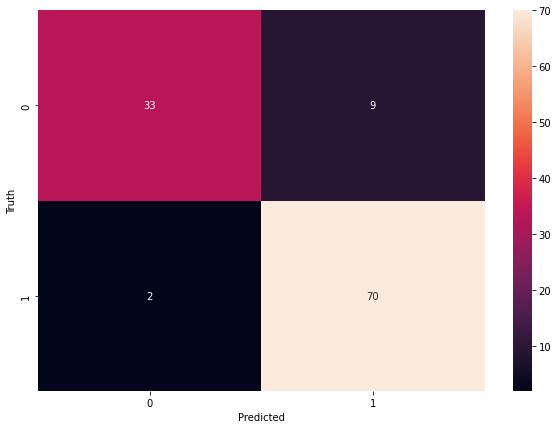

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 7))
sns.heatmap(matrix, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

## [Lecture 10.4: Implementation of GradBoost](https://www.youtube.com/watch?v=a7ziskNh0DY)

### Gradient Boost
The principle behind boosting algorithms is that first we build a model on the training dataset, then a second model is built to rectify the errors present in the first model. This procedure is continued until and unless the errors are minimized, and the dataset is predicted correctly. In particular, we start with a weak model and subsequently, each new model is fit on a modified version of the original dataset.

Notes:
- A weak learner is a model that performs at least slightly better than a random model
- Decision Trees are generally used as weak learners in gradient boost
- Unlike AdaBoost where decision trees with only one level (decision stumps) are used. The decision tree used in Gradient Boost generally contain some 3-7 levels.

### Steps
In this notebook, we implement Gradient Boost algorithm and show how it works for regression. Following are the steps involved:
1. Make a first guess $y_train$ and $y_test$ using the average of $y_train$

> $$y_{train_{p0}} = \frac{1}{n} \sum_{i=1}^{n} y_{train_i}$$
> $$y_{test_{p0}} = y_{train_{p0}}$$
2. Calculate the residuals from the training data set.
> $$r_0 = y_train - y_{train_{p0}}$$
3. Fit the weak learner to the residuals minimizing the loss function. Let's call it $f_0$
> $$r_0 = f_0(X_train)$$
4. Increment the predicted y's.
> $$y_{train_{p1}} = y_{train_{p0}} + \alpha f_0(X_train)$$
> $$y_{test_{p1}} = y_{test_{p0}} + \alpha f_0(X_test)$$
> where $\alpha$ is learning rate
5. Repeat Steps 2 through 4 until you reach the number of boosting rounds

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

We will need to run several iterations, so lets create a function to implement GradBoost

In [13]:
def GradBoost(model, X_train, y_train, X_test, boosting_rounds, learning_rate: float=0.1):
    # make a first guess of our training target variable using the mean of y_train
    y_hat_train = np.repeat(np.mean(y_train), len(y_train))

    # initialize the test prediction with mean of the training target variable
    y_hat_test = np.repeat(np.mean(y_train), len(X_test))

    # calculate the residuals from the training data using the first guess
    residuals = y_train - y_hat_train

    # iterates through the boosting rounds
    for i in range(0, boosting_rounds):
        # fit the model to the residuals
        model = model.fit(X_train, residuals)

        # increment the predicted training y with the pseudo residual + learning rate
        y_hat_train = y_hat_train + learning_rate * model.predict(X_train)

        # increment the predicted test y as well
        y_hat_test = y_hat_test + learning_rate * model.predict(X_test)

        # calculate the residuals for the next round
        residuals = y_train - y_hat_train
        
    return y_hat_train, y_hat_test

We will create a synthetic dataset on which we will apply Gradient Boost

In [14]:
from sklearn.datasets import make_regression

X, y = make_regression(n_samples=1000,
                       n_features=20,
                       n_informative=15,
                       n_targets=1,
                       bias=0.0,
                       noise=20,
                       shuffle=True,
                       random_state=13)

X_train = X[0:800]
y_train = y[0:800]

X_test = X[800:]
y_test = y[800:]


The weak learner that we will use is DecisionTreeRegressor with the depth of 3, We can also use other regressors such as linear regression, ridge regression etc.

In [15]:
from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor(criterion='squared_error', max_depth=3)

Let us now see how the squared_error reduces as we keep increasing the number of boosting rounds

We will store the errors in the list, and will plot further.

In [17]:
mse_train = []
n_rounds = np.arange(5, 101, 5)
for n_round in n_rounds:
    y_hat_train = GradBoost(model,
                            X_train,
                            y_train,
                            X_test,
                            boosting_rounds=n_round,
                            learning_rate=0.1)[0]
    
    mse_train.append(np.mean((y_train - y_hat_train)**2))

Let's plot the reduction in training error w.r.t the number of boosting rounds (We can similarly plot for test_error).

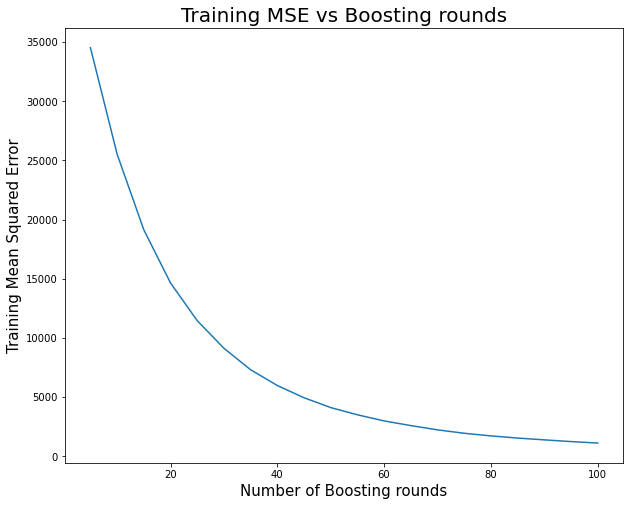

In [18]:
plt.figure(figsize=(10, 8))

plt.plot(n_rounds, mse_train)
plt.title('Training MSE vs Boosting rounds', fontsize=20)
plt.xlabel('Number of Boosting rounds', fontsize=15)
plt.ylabel('Training Mean Squared Error', fontsize=15)
plt.show()

#### boosting_rounds=0
We can also compare the actual target values with the predicted values for a given boosting_rounds value. Initially, we consider the mean of y_train values as the prediction. Let's plot that

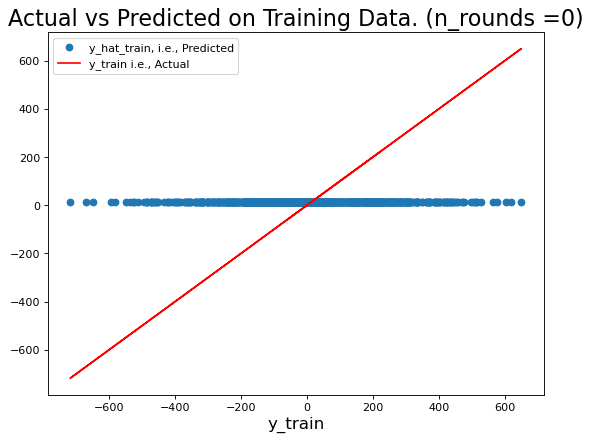

In [20]:
fig = plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

n_rounds=0
y_hat_train, y_hat_test = GradBoost(model,
                                    X_train,
                                    y_train,
                                    X_test,
                                    boosting_rounds=n_rounds,
                                    learning_rate=0.1)

plt.scatter (y_train, y_hat_train, label='y_hat_train, i.e., Predicted')
plt.title('Actual vs Predicted on Training Data. (n_rounds ='+ str(n_rounds)+')', fontsize=20)
plt.xlabel('y_train', fontsize=15)
plt.plot(y_train, y_train, color='r', label='y_train i.e., Actual')
plt.legend()
plt.show()

(Similarly we can also plot for y_test, y_test_hat)

#### boosting_rounds=10
We can see how's the prediction gets better as the number of training rounds is increased to 10.

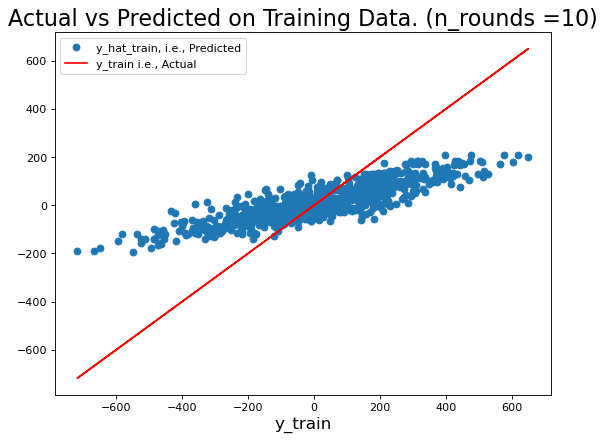

In [21]:
fig = plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

n_rounds=10
y_hat_train, y_hat_test = GradBoost(model,
                                    X_train,
                                    y_train,
                                    X_test,
                                    boosting_rounds=n_rounds,
                                    learning_rate=0.1)

plt.scatter (y_train, y_hat_train, label='y_hat_train, i.e., Predicted')
plt.title('Actual vs Predicted on Training Data. (n_rounds ='+ str(n_rounds)+')', fontsize=20)
plt.xlabel('y_train', fontsize=15)
plt.plot(y_train, y_train, color='r', label='y_train i.e., Actual')
plt.legend()
plt.show()

#### boosting_rounds=100
We can see how's the prediction gets better as the number of training rounds is increased to 100.

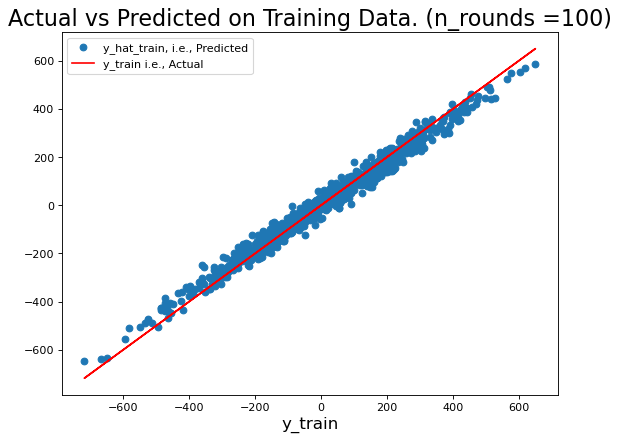

In [22]:
fig = plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

n_rounds=100
y_hat_train, y_hat_test = GradBoost(model,
                                    X_train,
                                    y_train,
                                    X_test,
                                    boosting_rounds=n_rounds,
                                    learning_rate=0.1)

plt.scatter (y_train, y_hat_train, label='y_hat_train, i.e., Predicted')
plt.title('Actual vs Predicted on Training Data. (n_rounds ='+ str(n_rounds)+')', fontsize=20)
plt.xlabel('y_train', fontsize=15)
plt.plot(y_train, y_train, color='r', label='y_train i.e., Actual')
plt.legend()
plt.show()

#### boosting_rounds=500
We can see how's the prediction gets better as the number of training rounds is increased to 500.

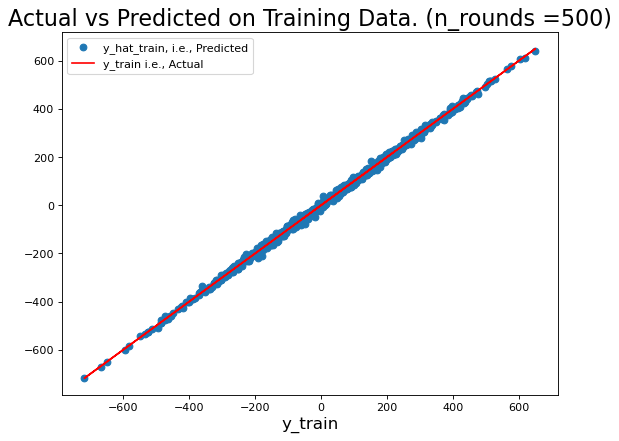

In [23]:
fig = plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

n_rounds=500
y_hat_train, y_hat_test = GradBoost(model,
                                    X_train,
                                    y_train,
                                    X_test,
                                    boosting_rounds=n_rounds,
                                    learning_rate=0.1)

plt.scatter (y_train, y_hat_train, label='y_hat_train, i.e., Predicted')
plt.title('Actual vs Predicted on Training Data. (n_rounds ='+ str(n_rounds)+')', fontsize=20)
plt.xlabel('y_train', fontsize=15)
plt.plot(y_train, y_train, color='r', label='y_train i.e., Actual')
plt.legend()
plt.show()